In [1]:
%gui wx
import sys
import os

#####################
# Import of utils.py functions
#####################
# Required to get utils.py and access its functions
notebook_dir = os.path.abspath("")
parent_dir = os.path.abspath(os.path.join(notebook_dir, '..'))
sys.path.append(parent_dir)
sys.path.append('.')
from utils import loadFSL, FSLeyesServer, mkdir_no_exist, interactive_MCQ,get_json_from_file

####################
# DIPY_HOME should be set prior to import of dipy to make sure all downloads point to the right folder
####################
os.environ["DIPY_HOME"] = "/home/jovyan/data"


#############################
# Loading fsl and freesurfer within Neurodesk
# You can find the list of available other modules by clicking on the "Softwares" tab on the left
#############################
import lmod
await lmod.purge(force=True)
await lmod.load('fsl/6.0.7.4')
await lmod.load('freesurfer/7.4.1')
await lmod.list()

####################
# Setup FSL path
####################
loadFSL()

###################
# Load all relevant libraries for the lab
##################
import fsl.wrappers
from fsl.wrappers import fslmaths

import mne_nirs
import nilearn
from nilearn.datasets import fetch_development_fmri

import mne
import mne_nirs
import dipy
from dipy.data import fetch_bundles_2_subjects, read_bundles_2_subjects
import xml.etree.ElementTree as ET
import os.path as op
import nibabel as nib
import glob

import ants
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report


# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# FSL function wrappers which we will call from python directly
from fsl.wrappers import fast, bet
from fsl.wrappers.misc import fslroi
from fsl.wrappers import flirt

# General purpose imports to handle paths, files etc
import glob
import pandas as pd
import numpy as np
import json

from IPython.display import display, HTML


In [2]:
################
# Start FSLeyes (very neat tool to visualize MRI data of all sorts) within Python
################
fsleyesDisplay = FSLeyesServer()
fsleyesDisplay.show()


(ipykernel_launcher.py:3744): Gtk-CRITICAL **: 14:54:11.474: gtk_window_resize: assertion 'height > 0' failed


In [5]:
import subprocess

dataset_id = 'ds000171'
subject = '01'

sample_path = "/home/jovyan/data/dataset"
mkdir_no_exist(sample_path)
bids_root = op.join(os.path.abspath(""),sample_path, dataset_id)
print(bids_root)
deriv_root = op.join(bids_root, 'derivatives')
preproc_root = op.join(bids_root, 'derivatives','preprocessed_data')

fmap_path = op.join(bids_root, 'sub-control01', 'func')
subject_dir = 'sub-control{}'.format(subject)



# Simple variant to include everything from subject-01
subprocess.run(["openneuro-py", "download", "--dataset", dataset_id, # Openneuro has for each dataset a unique identifier
                "--target-dir", bids_root,  # The path where we want to save our data. You should save your data under /home/jovyan/Data/[your dataset ID] to be 100% fool-proof
                "--include", subject_dir # Effectively get all data
               ], check=True)

/home/jovyan/data/dataset/ds000171

👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000171 …


📁 Traversing directories for ds000171 : 18 entities [00:09,  2.00 entities/s]


📥 Retrieving up to 15 files (5 concurrent downloads). 


sub-control01_T1w.nii.gz:   0%|          | 0.00/8.77M [00:00<?, ?B/s]
sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 0.00/33.9M [00:00<?, ?B/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 0.00/33.8M [00:00<?, ?B/s]


sub-control01_T1w.nii.gz:   1%|          | 49.5k/8.77M [00:00<00:32, 280kB/s]0<?, ?B/s]



sub-control01_task-music_run-3_events.tsv:   0%|          | 0.00/339 [00:00<?, ?B/s]



                                                                                    
sub-control01_task-music_run-2_bold.nii.gz:   0%|          | 66.6k/33.9M [00:00<01:34, 375kB/s]

sub-control01_task-music_run-1_bold.nii.gz:   0%|          | 83.6k/33.8M [00:00<01:15, 470kB/s]


sub-control01_T1w.nii.gz:   1%|          | 100k/8.77M [00:00<00:32, 283kB/s] 00<01:37, 362kB/s]

sub-control01_task-music_run-1_bold.nii.gz:   1%|          | 254k/33.8M [00:00<00:34, 1.03MB/s]
sub-control01_task-music_run-2_bold.nii.gz:   1%|          | 271k/33.9M [00:00<00:38, 908kB/s] 


s

✅ Finished downloading ds000171.
 
🧠 Please enjoy your brains.
 





sub-control01_task-music_run-3_bold.nii.gz: 100%|█████████▉| 33.8M/33.9M [00:17<00:00, 2.82MB/s]


                                                                                                

CompletedProcess(args=['openneuro-py', 'download', '--dataset', 'ds000171', '--target-dir', '/home/jovyan/data/dataset/ds000171', '--include', 'sub-control01'], returncode=0)

In [6]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [9]:
import os.path as op

# Set the root of the BIDS dataset
#bids_root_demo = 'data/dataset/ds000171/sub-control01/ds000171'  # Update this to the actual path

# Reset overlays in FSLeyes
fsleyesDisplay.resetOverlays()

# Load a specific functional file
fsleyesDisplay.load(op.join(bids_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold.nii.gz'))


Text(0, 0.5, 'Mean voxel intensity')

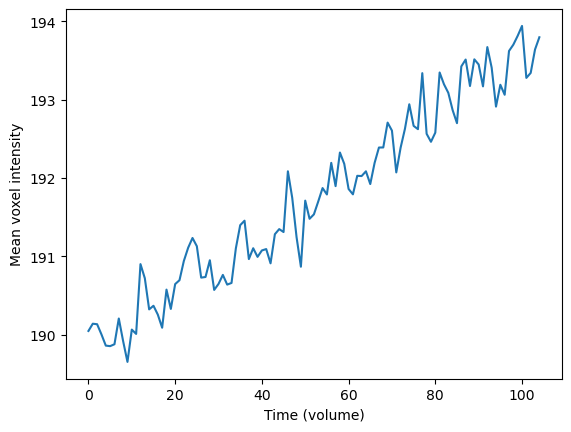

In [10]:
import matplotlib.pyplot as plt
import nibabel as nib

plt.plot(nib.load(op.join(bids_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold.nii.gz')).get_fdata().mean(axis=(0,1,2)))
plt.xlabel('Time (volume)')
plt.ylabel('Mean voxel intensity')

In [17]:
print(preproc_root)
print(bids_root)

/home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data
/home/jovyan/data/dataset/ds000171


In [18]:
from fsl.wrappers import mcflirt


mkdir_no_exist(deriv_root)
mkdir_no_exist(preproc_root)
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01'))
mkdir_no_exist(os.path.join(preproc_root, 'sub-control01', 'func'))



path_original_data = os.path.join(bids_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold.nii.gz')
path_moco_data = os.path.join(preproc_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold_moco')
mcflirt(infile=path_original_data,o=path_moco_data, plots=True, report=True, dof=6, mats=True)

Processed data will be saved as /home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data/sub-control01/func/sub-control01_task-music_run-1_bold_moco

McFLIRT v 2.0 - FMRI motion correction

Reading time series... 
first iteration - 8mm scaling, set tolerance
Rescaling reference volume [52] to 8 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
second iteration - drop to 4mm scaling
Rescaling reference volume [52] to 4 mm pixels
Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87]

refnum = 52
Original_refvol = -1


Registering volumes ... [53][54][55][56][57][58][59][60][61][62][63][64][65][66][67][68][69][70][71][72][73][74][75][76][77][78][79][80][81][82][83][84][85][86][87][88][89][90][91][92][93][94][95][96][97][98][99][100][101][102][103][104][51][50][49][48][47][46][45][44][43][42][41][40][39][38][37][36][35][34][33][32][31][30][29][28][27][26][25][24][23][22][21][20][19][18][17][16][15][14][13][12][11][10][9][8][7][6][5][4][3][2][1][0]
Saving motion corrected time series... 


{}

In [19]:
print_dir_tree(bids_root, max_depth=5)

|ds000171/
|--- CHANGES
|--- README
|--- dataset_description.json
|--- participants.tsv
|--- derivatives/
|------ preprocessed_data/
|--------- sub-control01/
|------------ func/
|--------------- sub-control01_task-music_run-1_bold_moco.nii.gz
|--------------- sub-control01_task-music_run-1_bold_moco.par
|--------------- sub-control01_task-music_run-1_bold_moco.mat/
|--- sub-control01/
|------ anat/
|--------- sub-control01_T1w.nii.gz
|------ func/
|--------- sub-control01_task-music_run-1_bold.nii.gz
|--------- sub-control01_task-music_run-1_events.tsv
|--------- sub-control01_task-music_run-2_bold.nii.gz
|--------- sub-control01_task-music_run-2_events.tsv
|--------- sub-control01_task-music_run-3_bold.nii.gz
|--------- sub-control01_task-music_run-3_events.tsv
|--------- sub-control01_task-nonmusic_run-4_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-4_events.tsv
|--------- sub-control01_task-nonmusic_run-5_bold.nii.gz
|--------- sub-control01_task-nonmusic_run-5_events.tsv


In [20]:
fsleyesDisplay.resetOverlays()
fsleyesDisplay.load(path_original_data)
fsleyesDisplay.load(path_moco_data)

In [21]:
def load_mot_params_fsl_6_dof(path):
    return pd.read_csv(path, sep='  ', header=None, 
            engine='python', names=['Rotation x', 'Rotation y', 'Rotation z','Translation x', 'Translation y', 'Translation z'])

mot_params = load_mot_params_fsl_6_dof(op.join(preproc_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold_moco.par'))
mot_params

,Rotation x,Rotation y,Rotation z,Translation x,Translation y,Translation z
0,0.000843,0.000589,-0.000283,-0.020640,-0.088168,-0.061575
1,0.000587,0.000481,-0.000326,-0.020651,-0.071060,-0.046486
2,0.000933,0.000589,-0.000394,-0.020618,-0.046722,-0.035206
3,0.000550,0.000816,-0.000394,-0.020571,-0.072742,-0.049830
4,0.000858,0.000589,-0.000394,-0.020618,-0.060591,-0.083145
...,...,...,...,...,...,...
100,0.000952,-0.000853,0.000040,-0.013383,0.118385,0.187859
101,0.000457,-0.001224,0.000051,-0.009799,0.133098,0.214907
102,0.001244,-0.001305,0.000298,-0.028813,0.134919,0.187284
103,0.000731,-0.001537,0.000073,-0.030532,0.127386,0.185354


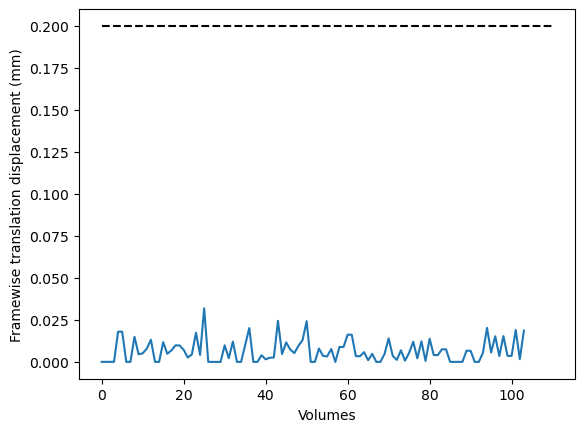

In [24]:
# write your code here to inspect quickly the translation on X :)
#%matplotlib inline

# Getting the translation is easy
trans_x = mot_params["Translation x"]
# Now, we want a 0.2mm with respect to previous frame:
disp_x = np.diff(trans_x)
# Lastly, we can ask for displacements (in absolute value) above 0.2mm and plot it to be clear:
threshold=0.2
plt.plot(np.abs(disp_x))
plt.hlines(threshold, 0, 110,colors='black', linestyles='dashed', label='FD threshold')
plt.xlabel("Volumes")
plt.ylabel("Framewise translation displacement (mm)")
plt.show()

# There are basically (if looking only along X translation) no frame displacement above 0.2mm!

In [25]:
def compute_FD_power(mot_params):
    framewise_diff = mot_params.diff().iloc[1:]

    rot_params = framewise_diff[['Rotation x', 'Rotation y', 'Rotation z']]
    # Estimating displacement on a 50mm radius sphere
    # To know this one, we can remember the definition of the radian!
    # Indeed, let the radian be theta, the arc length be s and the radius be r.
    # Then theta = s / r
    # We want to determine here s, for a sphere of 50mm radius and knowing theta. Easy enough!
    
    # Another way to think about it is through the line integral along the circle.
    # Integrating from 0 to theta with radius 50 will give you, unsurprisingly, r0 theta.
    converted_rots = rot_params*50
    trans_params = framewise_diff[['Translation x', 'Translation y', 'Translation z']]
    fd = converted_rots.abs().sum(axis=1) + trans_params.abs().sum(axis=1)
    return fd

fd = compute_FD_power(mot_params).to_numpy()

In [26]:
threshold = np.quantile(fd,0.75) + 1.5*(np.quantile(fd,0.75) - np.quantile(fd,0.25))

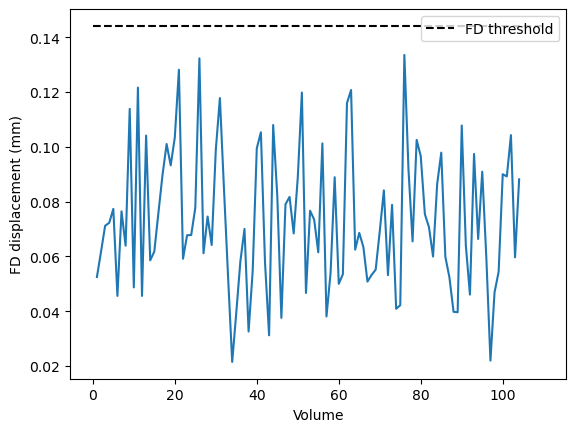

In [28]:
#%matplotlib inline
plt.plot(list(range(1, fd.size+1)), fd)
plt.xlabel('Volume')
plt.ylabel('FD displacement (mm)')
plt.hlines(threshold, 0, 110,colors='black', linestyles='dashed', label='FD threshold')
plt.legend()
plt.show()

In [29]:
np.where(fd > threshold)[0] + 1

array([], dtype=int64)

In [30]:
subprocess.run(['epi_reg'])


Usage: epi_reg [options] --epi=<EPI image> --t1=<wholehead T1 image> --t1brain=<brain extracted T1 image> --out=<output name>
 
Optional arguments
  --fmap=<image>         : fieldmap image (in rad/s)
  --fmapmag=<image>      : fieldmap magnitude image - wholehead extracted
  --fmapmagbrain=<image> : fieldmap magnitude image - brain extracted
  --gdc=<image>          : Gradient-distortion corection warpfield
  --wmseg=<image>        : white matter segmentation of T1 image
  --echospacing=<val>    : Effective EPI echo spacing (sometimes called dwell time) - in seconds
  --pedir=<dir>          : phase encoding direction, dir = x/y/z/-x/-y/-z
  --weight=<image>       : weighting image (in T1 space)
  --nofmapreg            : do not perform registration of fmap to T1 (use if fmap already registered) 
  --noclean              : do not clean up intermediate files
  -v                     : verbose output
  -h                     : display this help message
 
e.g.:  epi_reg --epi=example_func

CompletedProcess(args=['epi_reg'], returncode=1)

In [34]:
print(preproc_root)
print(bids_root)

/home/jovyan/data/dataset/ds000171/derivatives/preprocessed_data
/home/jovyan/data/dataset/ds000171


In [ ]:
from fsl.wrappers import epi_reg

#################
# Solution
# We use the motion corrected EPI 
##################
# We use the motion corrected EPI
epi_target = op.join(preproc_root, 'sub-control01/func', 'sub-control01_task-music_run-1_bold_moco')
whole_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
#skull_stripped_t1 = op.join(bids_root, 'sub-control01', 'anat', 'sub-control01_T1w')
output_path = op.join(preproc_root,'sub-control01/func', 'sub-control01_task-music_run-1_bold_bbr')
ref_vol_name =  op.join(preproc_root, 'sub-control01', 'func', 'sub-control01_task-music_run-1_bold_moco_vol_middle')

use_single_vol = True

if use_single_vol:
    # Extract the middle volume with fslroi as we've seen before :)
    fslroi(epi_target, ref_vol_name, str(52), str(1))#le 52 vient de 104/2, qui vient des motion correction par
    # Call epi_reg
    subprocess.run(['epi_reg','--epi={}'.format(ref_vol_name), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
else:
    subprocess.run(['epi_reg','--epi={}'.format(epi_target), '--t1={}'.format(whole_t1), '--t1brain={}'.format(skull_stripped_t1), '--out={}'.format(output_path)])
